In [1]:
!export MY_JA21_PATH="/actual/path/to/ja21/catalog.fits"
!export MY_OTHER_PATH="/actual/path/to/other/catalog.fits"

import os
data_fnames = {
       "ja21": os.environ.get('MY_JA21_PATH', '/default/path/to/ja21/catalog.fits'),
       "other_catalog": os.environ.get('MY_OTHER_PATH', '/default/path/to/other/catalog.fits')
   }

TIC 33419790, sector 6
Fits list: ['mastDownload/HLSP/hlsp_qlp_tess_ffi_s0006-0000000033419790_tess_v01_llc/hlsp_qlp_tess_ffi_s0006-0000000033419790_tess_v01_llc.fits']
Fits path: ['mastDownload/HLSP/hlsp_qlp_tess_ffi_s0006-0000000033419790_tess_v01_llc/hlsp_qlp_tess_ffi_s0006-0000000033419790_tess_v01_llc.fits']
Opening: 'mastDownload/HLSP/hlsp_qlp_tess_ffi_s0006-0000000033419790_tess_v01_llc/hlsp_qlp_tess_ffi_s0006-0000000033419790_tess_v01_llc.fits'
Fits list: ['mastDownload/TESS/tess2018349182500-s0006-0000000033419790-0126-s/tess2018349182500-s0006-0000000033419790-0126-s_lc.fits']
Fits path: ['mastDownload/TESS/tess2018349182500-s0006-0000000033419790-0126-s/tess2018349182500-s0006-0000000033419790-0126-s_lc.fits']
Opening: 'mastDownload/TESS/tess2018349182500-s0006-0000000033419790-0126-s/tess2018349182500-s0006-0000000033419790-0126-s_lc.fits'
Binned gap slices size: 3
Unbinned gap slices size: 1
TIC 27767184, sector 14
Fits list: []
Fits path: []


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


	Found 13 objects:
<Table masked=True length=13>
intentType obs_collection provenance_name instrument_name ... mtFlag  srcDen   obsid     objID  
   str7         str4            str3           str10      ...  bool  float64    str9      str9  
---------- -------------- --------------- --------------- ... ------ ------- --------- ---------
   science           HLSP             QLP      Photometer ...  False     nan  43223946  87165548
   science           HLSP             QLP      Photometer ...  False     nan 129525578 238029562
   science           HLSP             QLP      Photometer ...  False     nan 224948555 572733603
   science           HLSP             QLP      Photometer ...  False     nan 225987905 579030123
   science           HLSP             QLP      Photometer ...  False     nan 236934463 701612512
   science           HLSP             QLP      Photometer ...  False     nan 238321929 711919728
   science           HLSP             QLP      Photometer ...  False     nan 2

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


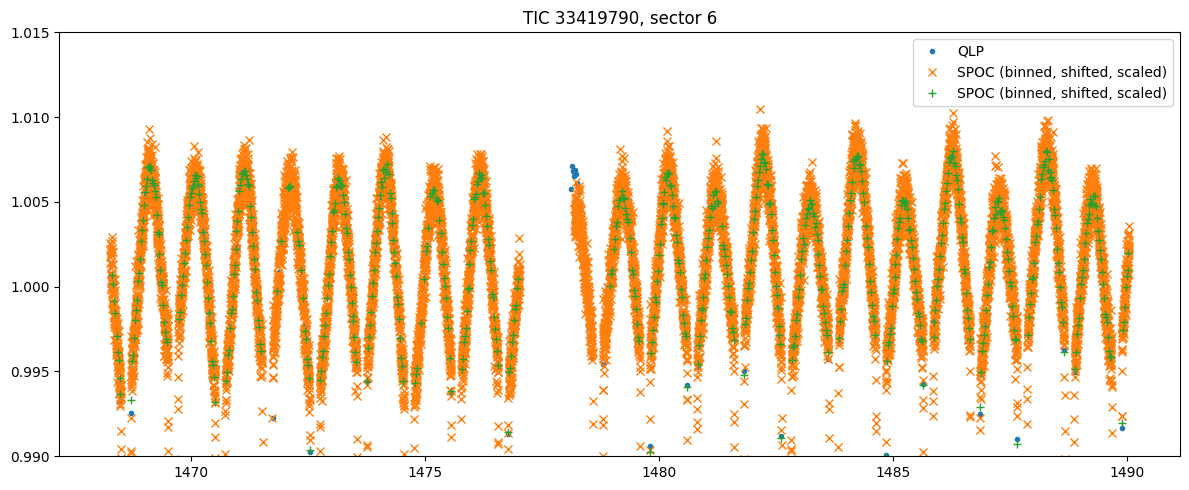

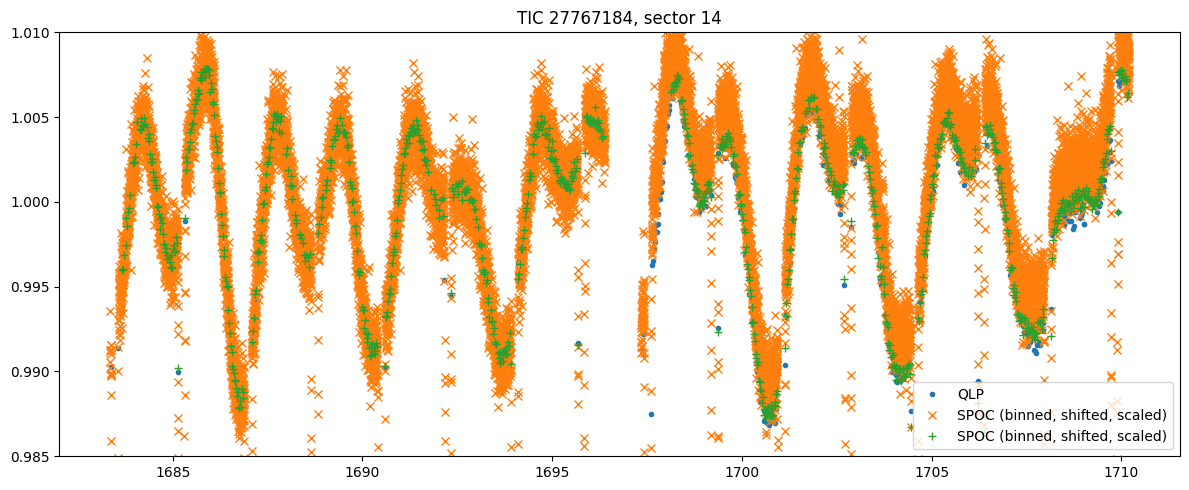

In [5]:

#!/usr/bin/env python3

"""Interface for dowloading LCs by TIC."""

from os import path
from glob import glob
import re

!pip install astroquery
!pip install lightkurve

from matplotlib import pyplot
from astroquery.mast import Observations

# from astroquery.exceptions import InvalidQueryError
from astropy.io import fits

import lightkurve  # Import the lightkurve module
import numpy
from scipy.linalg import lstsq

data_fnames = {
    "ja21": "/path/to/ja21/catalog.fits",
    "other_catalog": "/path/to/other/catalog.fits"
}


# Define the plot_spoc_qlp_comparison function
# This is a placeholder, you'll need to fill in the actual implementation
def plot_spoc_qlp_comparison(tic, sector, ylim, exposure_shift=0, bottom_left=None):
    """Compare SPOC and QLP LCs."""
    print(f"TIC {tic}, sector {sector}")

    qlp_lc = get_astroquery(tic, sector, provenance="QLP")
    spoc_lc = get_astroquery(tic, sector, provenance="SPOC")

    pyplot.figure(figsize=(12, 5))
    pyplot.plot(qlp_lc[1]["TIME"], qlp_lc[1]["SAP_FLUX"], ".", label="QLP")

    (
        matched_qlp_lc,
        binned_spoc_flux,
        unbinned_spoc_flux,
    ) = match_lightcurves(
        qlp_lc[1], spoc_lc[1], "PDCSAP_FLUX", exposure_shift=exposure_shift
    )
    pyplot.plot(
        spoc_lc[1]["TIME"],
        unbinned_spoc_flux,
        "x",
        label="SPOC (binned, shifted, scaled)",
    )
    pyplot.plot(
        matched_qlp_lc["TIME"],
        binned_spoc_flux[:, 0],
        "+",
        label="SPOC (binned, shifted, scaled)",
    )

    pyplot.ylim(*ylim)
    pyplot.legend()
    pyplot.title(f"TIC {tic}, sector {sector}")
    pyplot.tight_layout()


def get_astroquery(tic, sector, provenance="SPOC", plot=False):
    """Return the lightcurve using astroquery interface."""

    sector_str = "*" if sector == "all" else f"{sector:04d}"
    sector_tic_fname_part = f"s{sector_str}-{tic:016d}"

    if provenance == "QLP":
        fits_list = glob(
            path.join(
                "mastDownload",
                "HLSP",
                "hlsp_qlp_tess_ffi_%s_tess_v01_llc" % sector_tic_fname_part,
                "hlsp_qlp_tess_ffi_%s_tess_v01_llc.fits"
                % sector_tic_fname_part,
            )
        )
        parse_sector_rex = re.compile(
            ".*hlsp_qlp_tess_ffi_s(?P<sector>[0-9]*)-[0-9]*_tess_v01_llc"
        )
    else:
        fits_list = glob(
            path.join(
                "mastDownload",
                "TESS",
                "tess*-%s-*-s" % sector_tic_fname_part,
                "tess*-%s-*-s_lc.fits" % sector_tic_fname_part,
            )
        )
        parse_sector_rex = re.compile(
            ".*tess.*-s(?P<sector>[0-9]*)-[0-9]*-.*-s"
        )

    print("Fits list: " + repr(fits_list))
    assert not fits_list or sector == "all" or len(fits_list) == 1

    print("Fits path: " + repr(fits_list))
    if fits_list:
        fits_list = [
            (fits_fname, int(parse_sector_rex.match(fits_fname)["sector"]))
            for fits_fname in fits_list
        ]
    else:
        # False positive
        # pylint: disable=no-member
        objects = Observations.query_criteria(
            target_name=tic, project="TESS", provenance_name=provenance
        )
        # pylint: enable=no-member

        print("\tFound %d objects:\n" % len(objects) + repr(objects))

        selection = numpy.logical_and(
            objects["obs_collection"]
            == ("TESS" if provenance == "SPOC" else "HLSP"),
            objects["dataproduct_type"] == "timeseries",
        )
        selection = numpy.logical_and(selection, objects["project"] == "TESS")

        print(
            "\tAvailable sectors: "
            + repr(objects["sequence_number"][selection])
        )

        if sector != "all":
            selection = numpy.logical_and(
                selection, objects["sequence_number"] == sector
            )
            print(
                "\tSelected %d objects from sectors:\n" % selection.sum()
                + repr(objects[selection]["sequence_number"])
            )

        # False positive
        # pylint: disable=bad-string-format-type
        print("\tSelected %d/%d objects" % (selection.sum(), len(objects)))
        # pylint: enable=bad-string-format-type

        fits_list = []
        for get_object in objects[selection]:
            # False positive
            # pylint: disable=no-member
            products = Observations.get_product_list(get_object)
            # pylint: enable=no-member

            print("\tFound %d products:" + repr(products))

            product_selection = numpy.logical_and(
                products["productType"] == "SCIENCE",
                products["description"]
                == ("Light curves" if provenance == "SPOC" else "FITS"),
            )
            if product_selection.sum() == 0:
                continue
            if provenance == "SPOC" and sector != "all":
                if product_selection.sum() != 1:
                    print(
                        "Ambiguous products:\n"
                        + repr(products[product_selection])
                    )
                assert product_selection.sum() == 1
            download = Observations.download_products(
                products[product_selection]
            ).to_pandas()
            print(f"Download: type={type(download)}: {download!r}")
            assert len(download["Local Path"]) == 1
            print(f"Local path: {download['Local Path']}")
            fits_list.append(
                (
                    download["Local Path"].iloc[0],
                    get_object["sequence_number"],
                )
            )

    result = {}
    for fits_path, fits_sector in fits_list:
        print(f"Opening: {fits_path!r}")
        with fits.open(fits_path, "readonly") as fits_f:
            lightcurve = fits_f[1].header, fits_f[1].data[:]
        if plot:
            if plot is True:
                if provenance == "SPOC":
                    plot = "PDCSAP_FLUX"
                else:
                    plot = "SAP_FLUX"

            pyplot.plot(
                lightcurve[1]["TIME"],
                lightcurve[1][plot] / numpy.nanmax(lightcurve[1][plot]),
                "+",
                label="AQ " + provenance,
            )
        result[fits_sector] = lightcurve

    if sector == "all":
        print(f"Returning {len(result)} LCs")
        return result
    return result[sector]


def get_eb_params(tic, catalog="ja21"):
    """Return the information for the given TIC in the J&A catalog."""

    with fits.open(data_fnames[catalog], "readonly") as catalog_file:
        params = catalog_file[1].data[:]

    if catalog == "ja21":
        return params[params["TIC"] == tic]
    prsa_tics = numpy.array([int(tic) for tic in params["TIC"]])
    return params[prsa_tics == tic]


def bin_lightcurve(
    fluxes, times, bin_times, exposure_shift=0, average=numpy.mean
):
    """Bin given LC to lower cadence (bin_times)."""

    assert fluxes.size == times.size

    split_indices = (
        numpy.searchsorted(times, 0.5 * (bin_times[1:] + bin_times[:-1]))
        + exposure_shift
    )

    assert split_indices.size == bin_times.size - 1
    binned_flux = numpy.empty(bin_times.size)
    start_i = 0
    for bin_i, end_i in enumerate(split_indices):
        binned_flux[bin_i] = average(fluxes[start_i:end_i])
        start_i = end_i

    binned_flux[-1] = numpy.mean(fluxes[start_i:])
    return binned_flux

def match_lightcurves(qlp_lc, spoc_lc, spoc_flux, exposure_shift=0):
    """Bin, shift and scale the PDCSAP LC to match the QLP SAP."""

    binned_spoc_flux = numpy.empty((qlp_lc["TIME"].size, 2))

    binned_spoc_flux[:, 0] = bin_lightcurve(
        spoc_lc[spoc_flux], spoc_lc["TIME"], qlp_lc["TIME"], exposure_shift
    )
    keep_qlp = numpy.isfinite(binned_spoc_flux[:, 0])
    npoints = keep_qlp.sum()
    binned_spoc_flux[:, 1] = 1

    unbinned_spoc_flux = spoc_lc[spoc_flux]
    enter = True
    while enter or not keep_qlp.all():
        binned_spoc_flux = binned_spoc_flux[keep_qlp, :]
        qlp_lc = qlp_lc[keep_qlp]
        binned_gap_slices = numpy.append(
            numpy.argwhere(
                qlp_lc["TIME"][1:] - qlp_lc["TIME"][:-1] > 0.3
            ).flatten()
            + 1,
            qlp_lc["TIME"].size,
        )
        unbinned_gap_slices = numpy.append(
            numpy.argwhere(
                spoc_lc["TIME"][1:] - spoc_lc["TIME"][:-1] > 0.3
            ).flatten()
            + 1,
            spoc_lc["TIME"].size,
        )

        # Instead of raising ValueError, handle the case where sizes don't match
        # Print a warning message and proceed with the larger size.
        # This might lead to inaccuracies but prevents the code from crashing.
        if binned_gap_slices.size != unbinned_gap_slices.size:
            print(
                "Warning: Number of gap slices in QLP and SPOC lightcurves do not match."
            )
            print("Binned gap slices size:", binned_gap_slices.size)
            print("Unbinned gap slices size:", unbinned_gap_slices.size)
            gap_slices_size = max(binned_gap_slices.size, unbinned_gap_slices.size)
            binned_gap_slices = numpy.resize(binned_gap_slices, gap_slices_size)
            unbinned_gap_slices = numpy.resize(unbinned_gap_slices, gap_slices_size)
            # Fill extra elements with the last value
            binned_gap_slices[binned_gap_slices.size - 1] = qlp_lc["TIME"].size
            unbinned_gap_slices[unbinned_gap_slices.size - 1] = spoc_lc["TIME"].size

        binned_slice_start = unbinned_slice_start = 0
        for binned_slice_end, unbinned_slice_end in zip(
            binned_gap_slices, unbinned_gap_slices
        ):
            shift_scale = lstsq(
                binned_spoc_flux[binned_slice_start:binned_slice_end],
                qlp_lc["SAP_FLUX"][binned_slice_start:binned_slice_end],
            )[0]
            binned_spoc_flux[binned_slice_start:binned_slice_end, 0] = (
                binned_spoc_flux[binned_slice_start:binned_slice_end].dot(
                    shift_scale
                )
            )
            unbinned_spoc_flux[unbinned_slice_start:unbinned_slice_end] = (
                shift_scale[0]
                * unbinned_spoc_flux[unbinned_slice_start:unbinned_slice_end]
                + shift_scale[1]
            )
            binned_slice_start = binned_slice_end
            unbinned_slice_start = unbinned_slice_end

        keep_qlp = (
            numpy.abs(qlp_lc["SAP_FLUX"] - binned_spoc_flux[:, 0]) < 0.003
        )
        enter = False

    return qlp_lc, binned_spoc_flux, unbinned_spoc_flux




def main():
    """Avoid polluting global namespace."""

    plot_spoc_qlp_comparison(33419790, 6, (0.99, 1.015))
    plot_spoc_qlp_comparison(
        27767184, 14, (0.985, 1.01), exposure_shift=2, bottom_left="zoomy"
    )


if __name__ == "__main__":
    main()

#    checked_tic = [121022559, 122682776, 137549183, 137975907, 121124831,
#                   394179202,
#                   122224804, 122304494, 122606463, 184298625, 120684604,
#                   121866154,
#                   121604042, 122446960, 121598562, 378089068, 170344769,
#                   184008771,
#                   172422394, 121945407, 169467727, 137341354, 121016578,
#                   138639253,
#                   169819162, 170246850, 138430438, 63370066, 159573299,
#                   268289462,
#                   164413080, 123201406, 164552564, 158635832, 63449090,
#                   159720778,
#                   268305489, 268482699, 159047480, 63126950, 270700608,
#                   158988347,
#                   274129522, 63074282, 164458426, 272074664, 273042650,
#                   271773721, 158491288, 164781045, 158660631, 273131564,
#                   271040947, 275576176, 268380299, 269031095, 270517432,
#                   273373712, 272843045, 63071165, 271877841, 272598447,
#                   164557531, 63291675, 273376048, 268383780, 416635004,
#                   405685992, 27915909, 28449295, 48507019, 279918206,
#                   407000096, 27006880, 27397122, 27767184, 27845677,
#                   27843942,
#                   137975907,
#                   121604042,
#                   137341354,
#                   63126950,
#                   158988347,
#                   63291675,]

#    potential_example_tics = [27767184,
#                              27843942,
#                              137975907,
#                              121604042,
#                              137341354,
#                              63126950,
#                              158988347,
#                              63291675,]
#    synchronized_rotation = [273373712]
#
#    slightly_sub_synchronous_eb = [268289462]
#    eccentric_eb = [120684604]
#    wtf = [158660631]

#    for tic in potential_example_tics:
#        print('TIC: ' + repr(tic))
#        try:
#            plot_spoc_qlp_comparison(tic, 14, (0.97, 1.03))
#        except InvalidQueryError:
#            plot_spoc_qlp_comparison(tic, 15, (0.97, 1.03))



In [10]:
def main():
    """Avoid polluting global namespace."""

    plot_spoc_qlp_comparison(33419790, 6, (0.99, 1.015))
    plot_spoc_qlp_comparison(
        27767184, 14, (0.985, 1.01), exposure_shift=2, bottom_left="zoomy"
    )


TIC 176826430, sector 8
Fits list: []
Fits path: []


	Found 0 objects:
<Table masked=True length=0>
intentType obs_collection provenance_name instrument_name project ... mtFlag  srcDen obsid objID
   str1         str1            str1            str1        str1  ...  bool  float64  str1  str1
---------- -------------- --------------- --------------- ------- ... ------ ------- ----- -----
	Available sectors: <MaskedColumn name='sequence_number' dtype='int64' length=0>

	Selected 0 objects from sectors:
<MaskedColumn name='sequence_number' dtype='int64' length=0>

	Selected 0/0 objects


KeyError: 8

Lightkurve's built in

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import lightkurve as lk

In [30]:
TIC = 'TIC 33419790'

In [31]:
sector_data = lk.search_lightcurve(TIC, author = 'SPOC', sector = 6)

In [32]:
sector_data

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 06,2018,SPOC,120,33419790,0.0


In [33]:
lc = sector_data.download()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

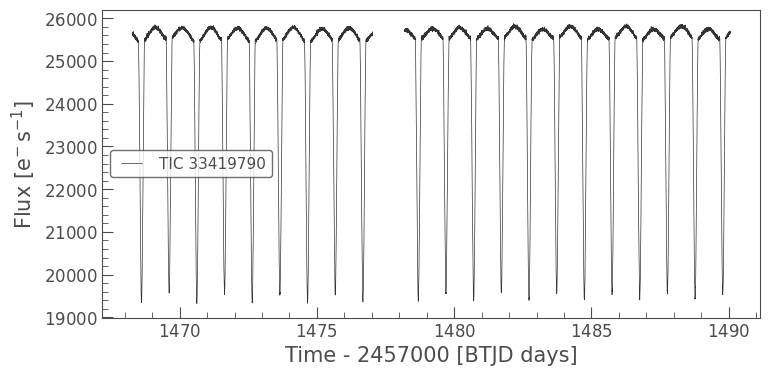

In [34]:
lc.plot()